In [1]:
%load_ext autoreload
%autoreload 2
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
root = '/home/bzr0014/Additive/'

In [2]:
!ls {root}files

April26_AMboneA1_volume_abs.h5	       low_transformed.np
April26_AMboneA1_volume_absorption.h5  mardas.model
April26_AMboneA1_volume_darkfield.h5   model20200216.keras
April27_AMA2_volume_abs.h5	       model20200225.keras
April27_AMA2_volume_darkfield.h5       model20200226_2.keras
high_3d.np			       model20200226_3.keras
high_transformed.np		       model20200226.keras
low_3d_dark.np			       resize.py
low_3d.np			       to_use_in_ml.np
low_transformed_dark.np


In [3]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import h5py
from joblib import load, dump
from sklearn.cluster import KMeans
from dask.distributed import LocalCluster, Client
from additive2 import utility
from additive2.config import *
import glob
from multiprocessing import Pool
from dask import compute, delayed
from additive2.utility import min_max_scale
from scipy.ndimage import zoom
import imageio

In [6]:
super_high_res_files = glob.glob("/home/bzr0014/Additive/LSU_NonHIP/0.7um/*tiff")
high_res_files = glob.glob("/home/bzr0014/Additive/LSU_NonHIP/2.9um/*tiff")

In [7]:
super_high_res_file = np.random.choice(super_high_res_files)
high_res_file = np.random.choice(high_res_files)
print(super_high_res_file)
super_high_res_img = imageio.imread(super_high_res_file)
high_res_img = imageio.imread(high_res_file)

/home/bzr0014/Additive/LSU_NonHIP/0.7um/LSU_DogboneNonHIP_0.7um_0274.tiff


In [12]:
resize_factor = .3
w, h = super_high_res_img.shape
new_shape = int(h*.7 * resize_factor), int(w*.7 * resize_factor)
resized_super_high_img = cv2.resize(super_high_res_img, new_shape)

In [13]:
w, h = high_res_img.shape
new_shape = int(h*2.9 * resize_factor), int(w*2.9 * resize_factor)
resized_high_img = cv2.resize(high_res_img, new_shape)

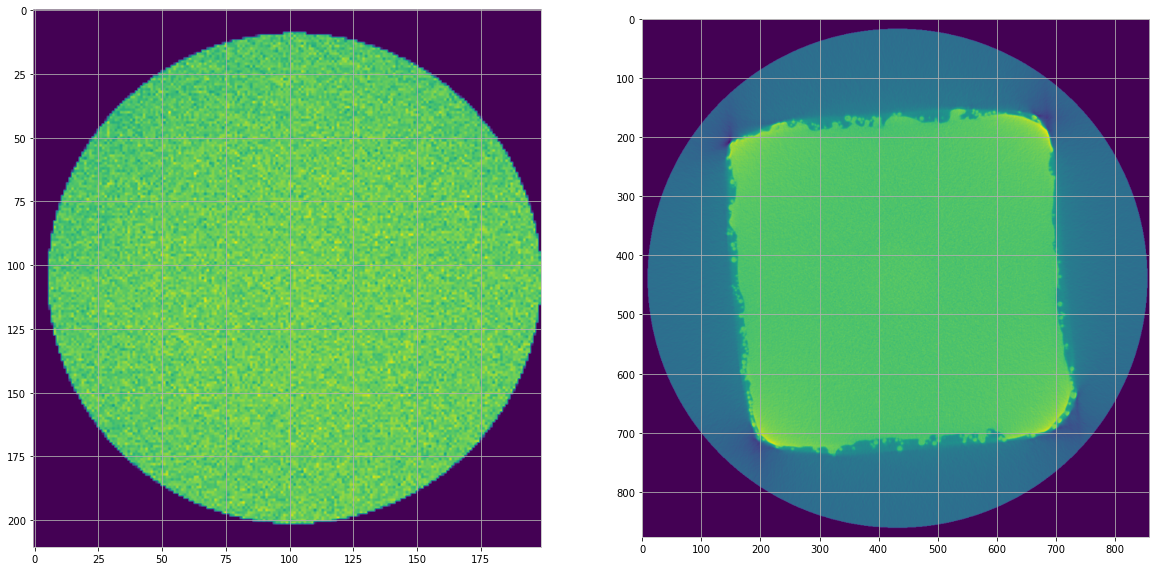

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(resized_super_high_img)
axes[1].imshow(resized_high_img)

In [8]:
from typing import Iterable
from itertools import count
from IPython.display import clear_output
def show_image_list(images: Iterable[np.ndarray], titles=None, sleep_time=1, figsize=(10, 10), 
                    start_title_index=0):
    if titles is None:
        titles = count(start_title_index)
    for title, image in zip(titles, images):
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(image)
        ax.set_title(title)
        plt.show()
        time.sleep(sleep_time)
        clear_output(True)

In [91]:
def overlap_images(small_img, big_img, top_left=(0, 0), mask=None, alpha=0, beta=1):
    w, h, *_ = small_img.shape
    top_left_x, top_left_y = top_left
    out = big_img.copy().astype('float32')
    if mask is None:
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h] = small_img
    else:
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h][mask] *= alpha
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h][mask] += small_img[mask] * beta
    return out

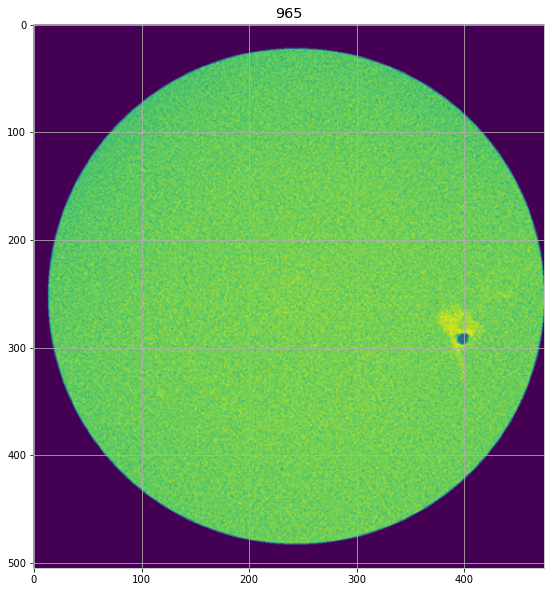

In [125]:
sleep_time = .5
start_index = 965
end_index = 966
show_image_list(
    (cv2.pyrDown(imageio.imread(x)) for x in super_high_res_files[start_index:end_index]), 
    sleep_time=sleep_time,  figsize=(10, 10), start_title_index=start_index
)

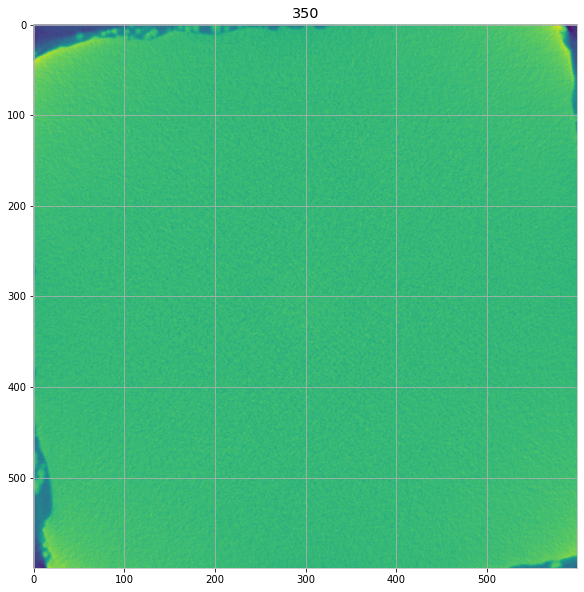

In [126]:
sleep_time = 1
start_index, end_index = 350, 351
show_image_list(
    (imageio.imread(x)[200:800, 200:800] for x in high_res_files[start_index:end_index]), 
    sleep_time=sleep_time,  figsize=(10, 10), start_title_index=start_index
)

We pick 436 and 230 from the hi-res image, the difference should be around {{ (436 - 230) * 2.9 }} 

In [134]:
center_holes = [68, 215, 292, 370, 373, 480, 581, 594, 965]
bottom_holes = [183, 483, 501, 508, 724, 894]
diffs = [(x, y, abs(x-y) * .7)
    for x in center_holes
    for y in bottom_holes
]
print(diffs)

[(68, 183, 80.5), (68, 483, 290.5), (68, 501, 303.09999999999997), (68, 508, 308.0), (68, 724, 459.2), (68, 894, 578.1999999999999), (215, 183, 22.4), (215, 483, 187.6), (215, 501, 200.2), (215, 508, 205.1), (215, 724, 356.29999999999995), (215, 894, 475.29999999999995), (292, 183, 76.3), (292, 483, 133.7), (292, 501, 146.29999999999998), (292, 508, 151.2), (292, 724, 302.4), (292, 894, 421.4), (370, 183, 130.9), (370, 483, 79.1), (370, 501, 91.69999999999999), (370, 508, 96.6), (370, 724, 247.79999999999998), (370, 894, 366.79999999999995), (373, 183, 133.0), (373, 483, 77.0), (373, 501, 89.6), (373, 508, 94.5), (373, 724, 245.7), (373, 894, 364.7), (480, 183, 207.89999999999998), (480, 483, 2.0999999999999996), (480, 501, 14.7), (480, 508, 19.599999999999998), (480, 724, 170.79999999999998), (480, 894, 289.79999999999995), (581, 183, 278.59999999999997), (581, 483, 68.6), (581, 501, 56.0), (581, 508, 51.099999999999994), (581, 724, 100.1), (581, 894, 219.1), (594, 183, 287.7), (594, 

We already matched 436
**It seems that the following points match in z axis:**

super high-res z | high-res  z | scaled high-res z| trimmed high-res z |
---------------|------------|----------------|------------------|
0|213|0|0
68|230|34|17
894|436|446|223
986|459|492|246

In [135]:
z_scale = (436 - 230)/(894 - 68)
xy_scale = .7/2.9

In [14]:
high_res_images_d = [delayed(lambda x: imageio.imread(x)[200:800, 200:800])(x) 
                   for x in high_res_files]
super_high_res_images_d = [
    delayed(lambda x:  imageio.imread(x))(x)  
    for x in super_high_res_files
]

In [15]:
high_res_images, super_high_res_images = compute(high_res_images_d, super_high_res_images_d)

In [16]:
high_res_images = np.array(high_res_images)
super_high_res_images = np.array(super_high_res_images)

In [139]:
trimmed_high_res = high_res_images[213:459]
trimmed_high_res.shape

(246, 600, 600)

In [140]:
scaled_super_hi_res = zoom(super_high_res_images, (z_scale*2, xy_scale*2, xy_scale*2), prefilter=False)


x/y | high-res | pyrDown(scaled scaled high-res) | scaled super high-res|
--|----------|-------------------------|----------------|
x|142|0|0
x|386|244|487|
y|158|0|0
y|387|229|458

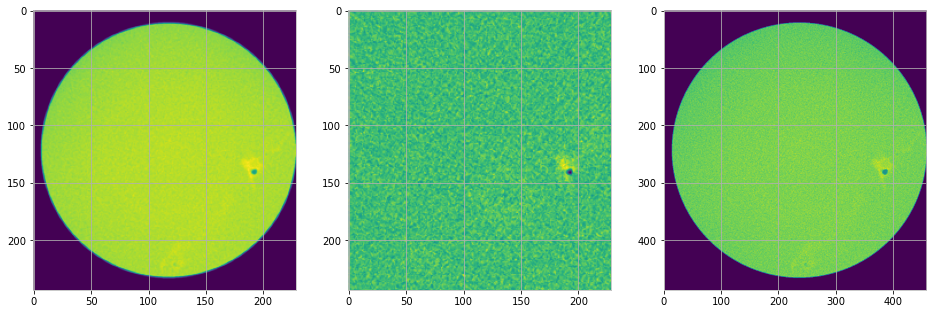

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
x_ = scaled_super_hi_res[34]
x = cv2.pyrDown(x_)
y = trimmed_high_res[17]
axes[0].imshow(x[0:244, 0:229])
axes[1].imshow(y[142:142+244, 158:158+229])
axes[2].imshow(x_[:488, :458])

(244, 229) (600, 600)


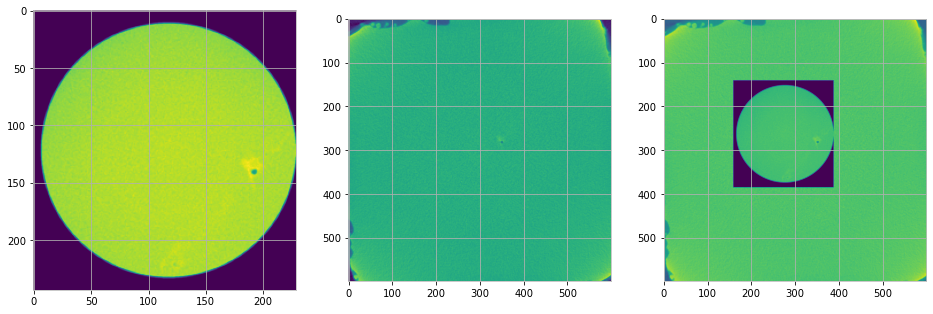

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
x = cv2.pyrDown(scaled_super_hi_res[34])
y = trimmed_high_res[17]
axes[0].imshow(x)
axes[1].imshow(y)

tmp_1 = y.copy()
w, h = x.shape
print(x.shape, y.shape)
tmp_1[xs:xs+w, ys:ys+h] = x
axes[2].imshow(tmp_1)

In [143]:
xyz_trimmed_high_res = trimmed_high_res[:, 142:142+244, 158:158+229]

In [144]:
import joblib
joblib.dump(ultra_trimmed_high_res, "../data/Additive/xyz_trimmed_high_res.np")
joblib.dump(scaled_super_hi_res, "../data/Additive/scaled_super_high_res_2x.np")

['../data/Additive/scaled_super_high_res_2x.np']

(244, 229)


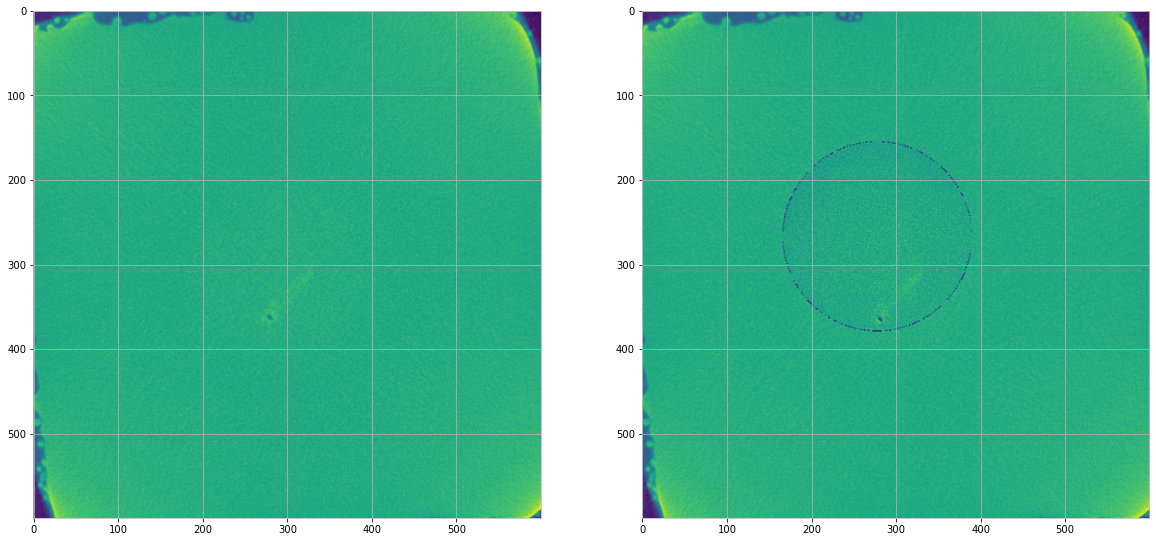

In [93]:
from scipy.ndimage import zoom
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
shr_ = zoom(imageio.imread(super_high_res_files[508]), .7/2.9)
print(shr_.shape)
hr_ = imageio.imread(high_res_files[436])[200:800, 200:800]
axes[0].imshow(hr_)
axes[1].imshow(overlap_images(shr_, hr_, top_left=(145, 160), mask=shr_!=0, alpha=.5, beta=.5))

# Drafts

In [146]:
scaled_super_hi_res.shape, xyz_trimmed_high_res.shape

((492, 487, 458), (246, 244, 229))

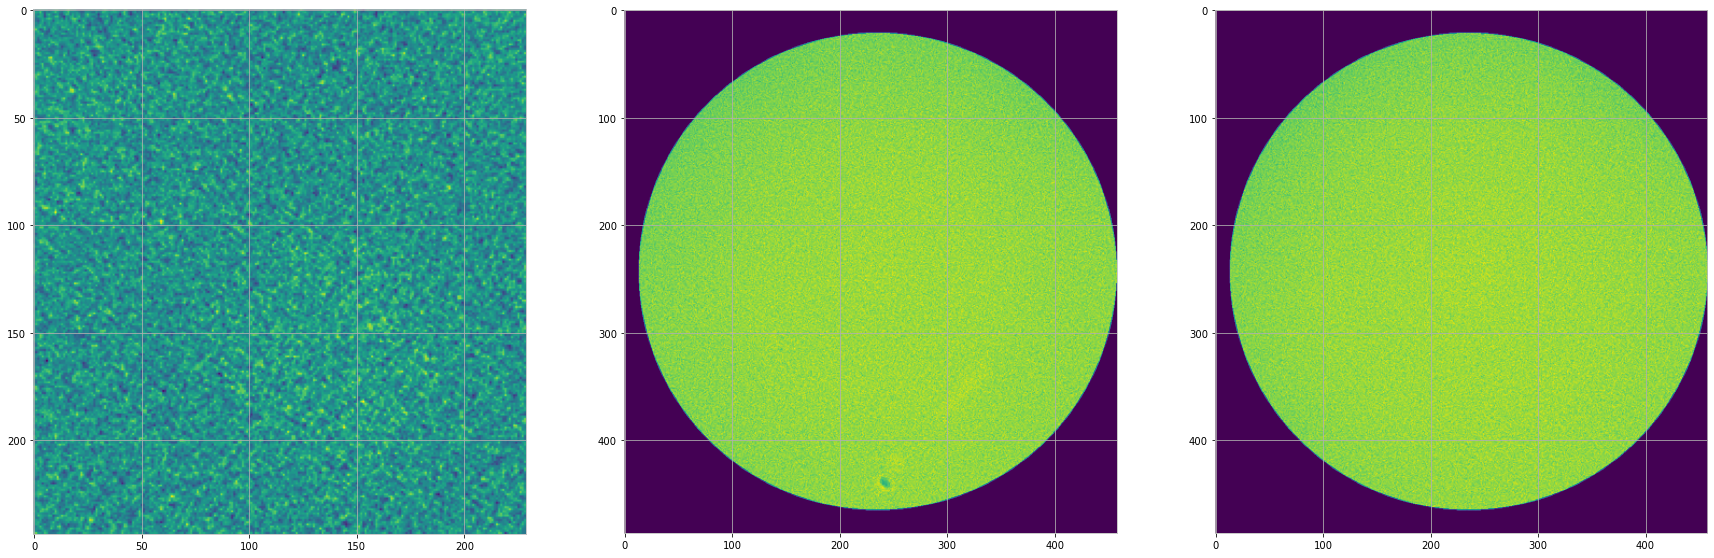

In [158]:
for n in range(200):
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    axes[0].imshow(xyz_trimmed_high_res[n])
    axes[1].imshow(scaled_super_hi_res[n*2])
    axes[2].imshow(scaled_super_hi_res[n*2+1])
    plt.show()
    time.sleep(.1)
    clear_output(True)

In [168]:
from functools import partial
blur_fun = partial(cv2.GaussianBlur, ksize=(11, 11), sigmaX=1)

In [175]:
from dask import delayed, compute
blurred_xyz_trimmed_high_res = [delayed(blur_fun)(x) for x in xyz_trimmed_high_res]
blurred_xyz_trimmed_high_res = np.array(compute(blurred_xyz_trimmed_high_res)[0])

In [210]:
import scipy
import pandas as pd
def get_local_minima(x, erode_filter):
    non_zero_filt = x>0
    non_zero = x[non_zero_filt]
    mn, mx, q1, q3, mean, std = pd.Series(non_zero).describe()[['min', 'max', '25%', '75%', 'mean', 'std']]
    iqr = q3 - q1
    out = x < q1 - 1.5 * iqr
    # out = x < mean - std
    # out = cv2.erode(out, np.ones(erode_filter))
    out = scipy.ndimage.binary_erosion(out, np.ones(erode_filter))
    return out & non_zero_filt

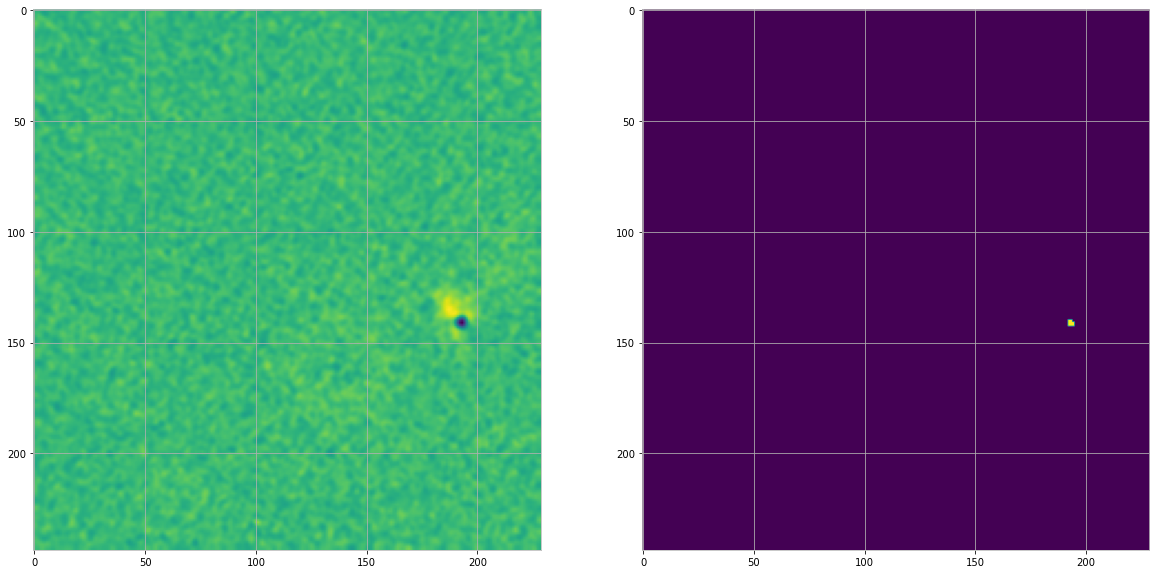

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
n = 17
axes[0].imshow((blurred_xyz_trimmed_high_res[n]))
axes[1].imshow(get_local_minima(blurred_xyz_trimmed_high_res[n], erode_filter=(3, 3)))

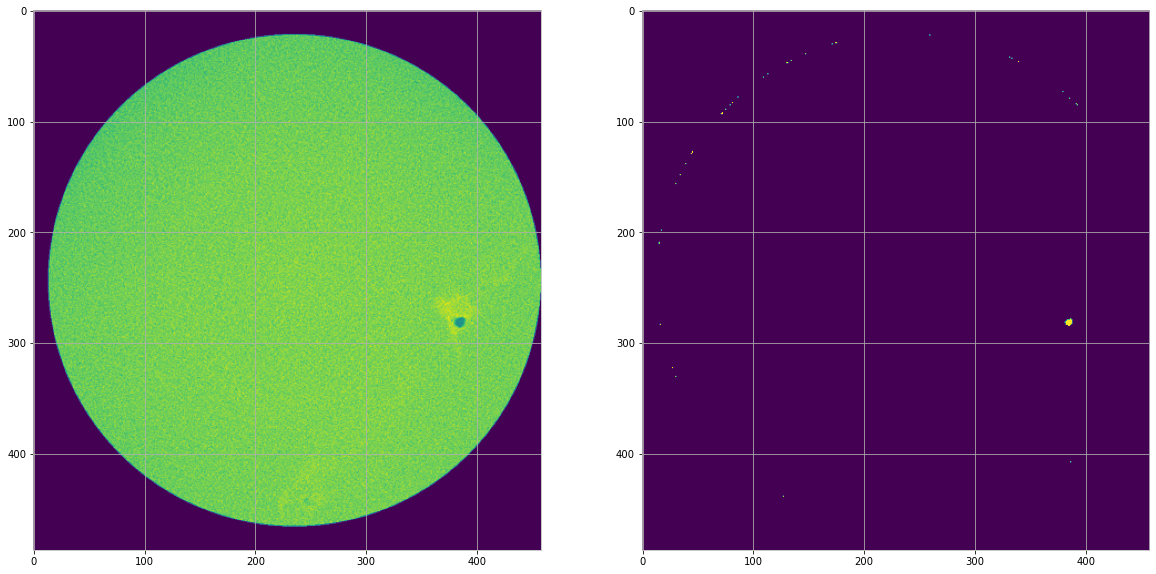

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
n = 34
axes[0].imshow((scaled_super_hi_res[n]))
axes[1].imshow(get_local_minima(scaled_super_hi_res[n], erode_filter=(3, 3)))

In [234]:
holes_trimed_high_res = [delayed(get_local_minima)(x, erode_filter=(3, 3)) 
                         for x in blurred_xyz_trimmed_high_res]
holes_trimed_high_res  = np.array(compute(holes_trimed_high_res)[0])

In [253]:
holes_super_high_res = [delayed(get_local_minima)(x, erode_filter=(3, 3)) 
                         for x in scaled_super_hi_res]
holes_super_high_res  = zoom(np.array(compute(holes_super_high_res)[0]), .5)

/home/bzr0014/miniconda3/envs/additive2/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [295]:
def make_low_res(img, s_noise):
    non_zero_pixels = img > 0 #assume non-negative
    non_zero_vals = img[non_zero_pixels]
    if len(non_zero_vals) == 0:
        return img
    mean, std = non_zero_vals.mean(), non_zero_vals.std()
    out = (img - mean) / std
    rnd = np.random.rand(*non_zero_vals.shape) * s_noise
    out[non_zero_pixels] += rnd
    return out

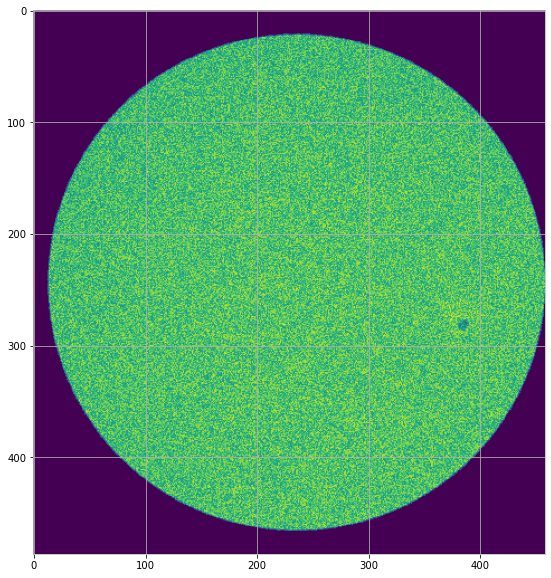

In [296]:
plt.imshow(make_low_res(scaled_super_hi_res[34], s_noise=8))

In [299]:
noisy_super_high_res = compute([delayed(make_low_res)(x, s_noise=8) for x in scaled_super_hi_res])[0]
noisy_super_high_res = np.array(noisy_super_high_res)

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'